In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from agents import agents
from utils.env_utils import make_gc_env_and_datasets
from utils.flax_utils import restore_agent
from utils.datasets import Dataset, GCDataset, HGCDataset
from agents.cfgrl import get_config

/home/jennifer/miniconda3/envs/fql/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
/home/jennifer/miniconda3/envs/fql/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [4]:
np.random.seed(0)
env, train_dataset, val_dataset = make_gc_env_and_datasets('antmaze-medium-navigate-singletask-v0', frame_stack=None)

In [5]:
agent_class = agents['cfgrl']
cfgrl_config = get_config()
dataset_class = eval(cfgrl_config['dataset_class'])

In [6]:
train_dataset = dataset_class(Dataset.create(**train_dataset), cfgrl_config)
example_batch = train_dataset.sample(1)

In [7]:
agent_map = {}
for i in range(1000000, 10000000, 1000000):
    agent_copy = agent_class.create(
        0,
        example_batch,
        cfgrl_config
    )
    agent = restore_agent(agent_copy, 'exp/cfgrl/Debug/sd000_20250611_164055', i)

    agent_map[i] = agent

Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_1000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_2000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_3000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_4000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_5000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_6000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_7000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_8000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250611_164055/params_9000000.pkl


In [8]:
from notebooks.utils import all_cells
all_cells = all_cells(env)

In [9]:
%reload_ext autoreload

In [10]:
from notebooks.utils import rollout, plot_axes, get_goals_list

In [11]:
# goal_coords = [
#     # [8, 8],
#     [15, 5],
#     [0, 15],
#     [12.5, 7.5],
    
# ]
# goals = get_goals_list(env, goal_coords)

# curr_agent = agent_map[7000000]

# num_rollouts = 12
# num_rows = 4
# trajs = []
# for _ in range(num_rollouts):
#     traj = rollout(env, goals, curr_agent, num_steps=100, temperature=0.2)
#     trajs.append(traj)

# fig, ax = plt.subplots(num_rows, num_rollouts // num_rows, figsize=(10, num_rows * 3))

# for i, traj in enumerate(trajs):
#     plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=goals)
# plt.tight_layout()
# plt.show()

In [12]:
from utils.evaluation import supply_rng
import jax
from notebooks.utils import rollout_fn

100%|██████████| 300/300 [00:00<00:00, 305.34it/s]


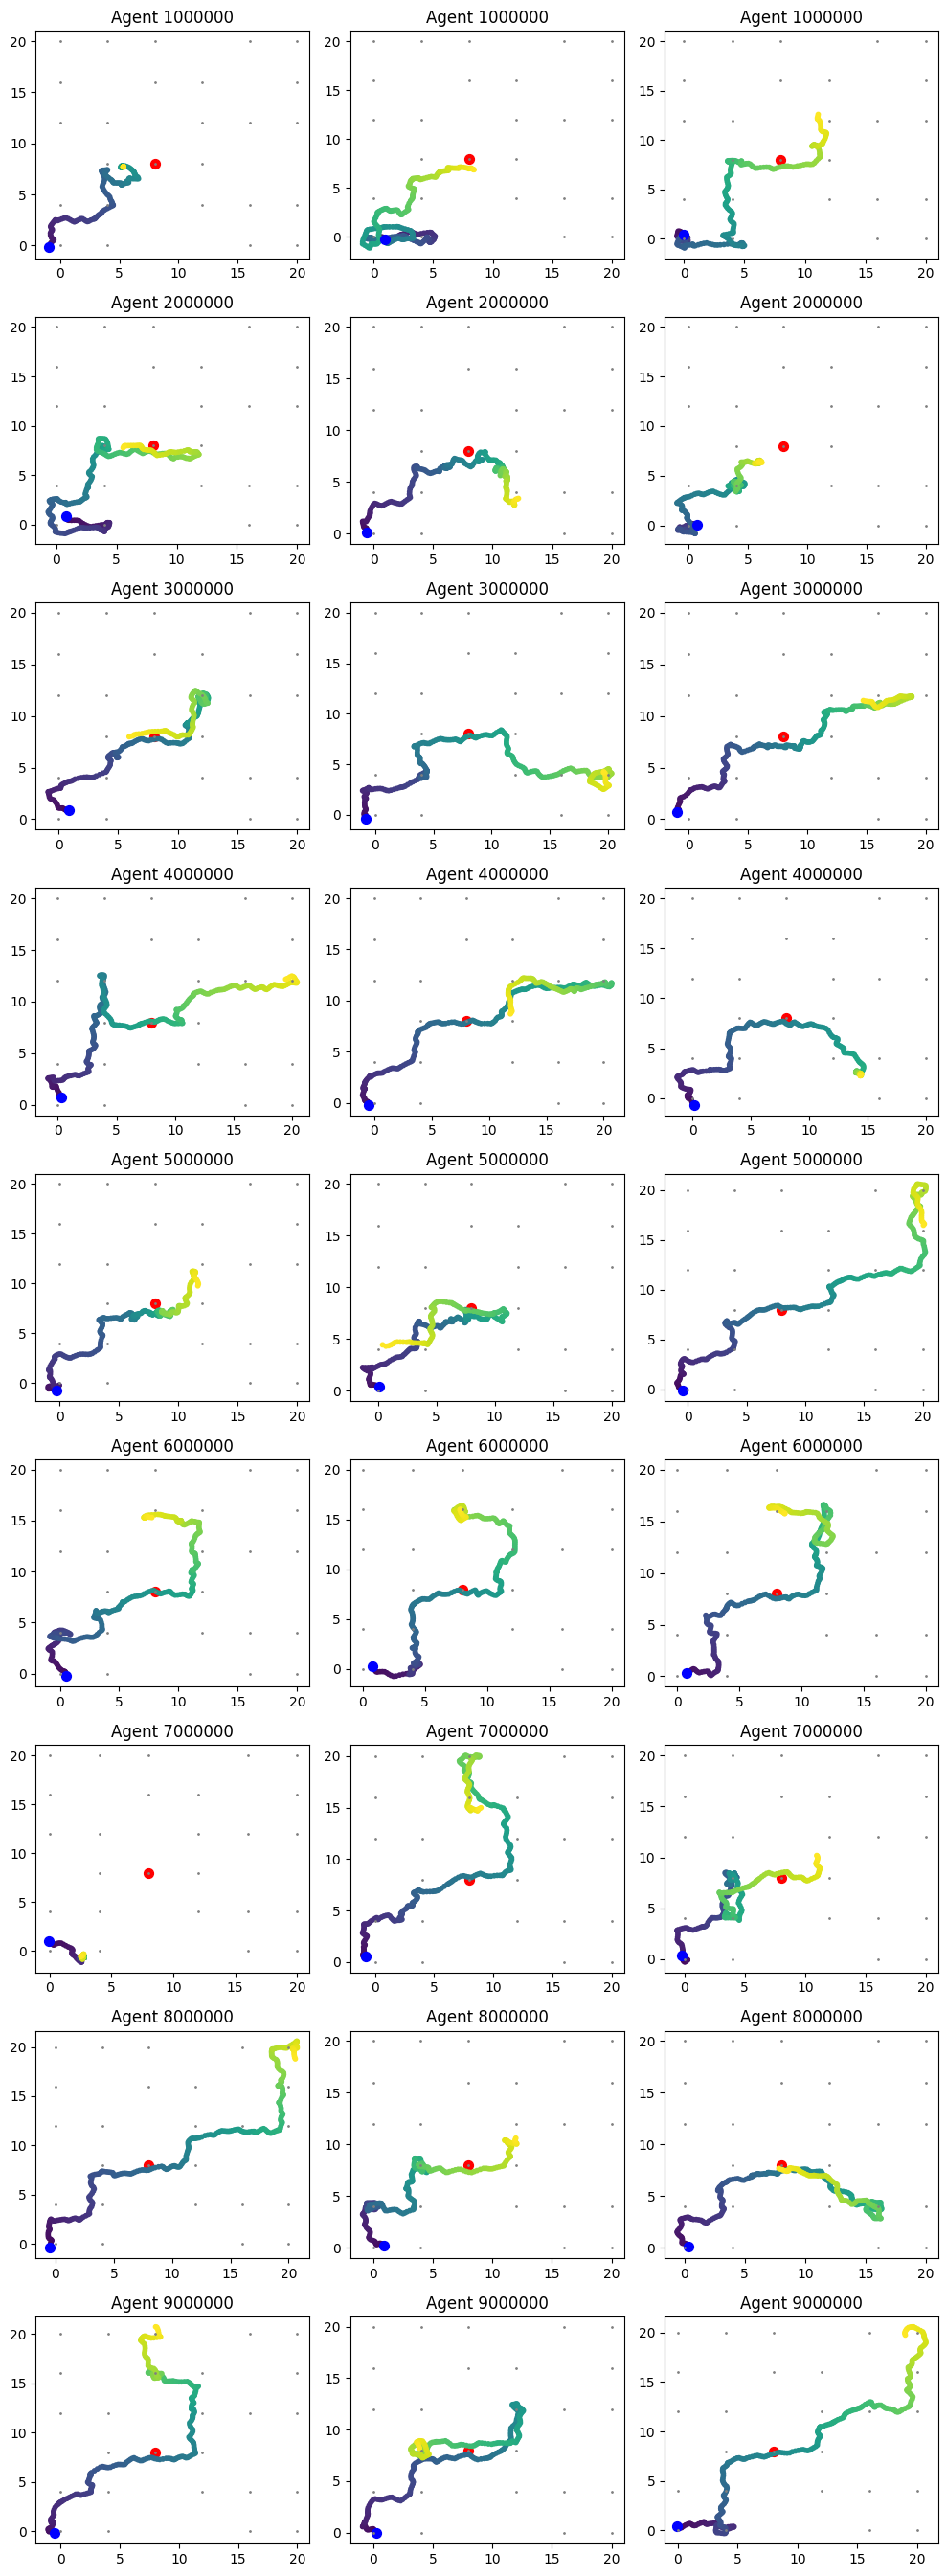

In [14]:
goal = [[8, 8]]
goal = get_goals_list(env, goal)

num_rollouts = 3
num_rows = len(agent_map)
trajs = { k : [] for k in agent_map.keys() }
for k in agent_map.keys():
    curr_agent = agent_map[k]
    curr_agent_fn = supply_rng(curr_agent.sample_actions, rng=jax.random.PRNGKey(0))
    for _ in range(num_rollouts):
        traj = rollout_fn(env, goal, curr_agent_fn, num_steps=300, temperature=0.2)
        trajs[k].append(traj['traj'])

fig, ax = plt.subplots(num_rows, num_rollouts, figsize=(10, num_rows * 3))

for i, k in enumerate(agent_map.keys()):
    for j, traj in enumerate(trajs[k]):
        plot_axes(ax[i, j], traj, all_cells=all_cells, goals=goal)
        ax[i, j].set_title(f'Agent {k}')

plt.tight_layout()
plt.show()

In [23]:
goal = [[20, 0]]
goal = get_goals_list(env, goal)

In [26]:
num_rollouts = 200
num_rows = len(agent_map)
trajs = { k : [] for k in agent_map.keys() }
goal_reached = { k : [] for k in agent_map.keys() }
final_ob_near_goal = { k : [] for k in agent_map.keys() }
for k in agent_map.keys():
    curr_agent = agent_map[k]
    curr_agent_fn = supply_rng(curr_agent.sample_actions, rng=jax.random.PRNGKey(0))
    for _ in range(num_rollouts):
        traj = rollout_fn(env, goal, curr_agent_fn, num_steps=300, temperature=0.2)
        trajs[k].append(traj['traj'])
        goal_reached[k].append(traj['goal_reached'])
        final_ob_near_goal[k].append(traj['final_ob_near_goal'])

for k in agent_map.keys():
    print(f'Agent {k}:')
    print(f'  Goal reached: {np.mean(goal_reached[k])}')
    print(f'  Final observation near goal: {np.mean(final_ob_near_goal[k])}')

100%|██████████| 300/300 [00:01<00:00, 281.47it/s]

Agent 1000000:
  Goal reached: 0.05
  Final observation near goal: 0.035
Agent 2000000:
  Goal reached: 0.115
  Final observation near goal: 0.1
Agent 3000000:
  Goal reached: 0.205
  Final observation near goal: 0.195
Agent 4000000:
  Goal reached: 0.4
  Final observation near goal: 0.345
Agent 5000000:
  Goal reached: 0.265
  Final observation near goal: 0.23
Agent 6000000:
  Goal reached: 0.255
  Final observation near goal: 0.25
Agent 7000000:
  Goal reached: 0.33
  Final observation near goal: 0.3
Agent 8000000:
  Goal reached: 0.24
  Final observation near goal: 0.185
Agent 9000000:
  Goal reached: 0.36
  Final observation near goal: 0.195


In [27]:
stitch_agent = agent.create(
    0,
    example_batch,
    cfgrl_config
)
stitch_agent = restore_agent(stitch_agent, 'exp/cfgrl/Debug/sd000_20250610_172218', 1000000)

nav_agent = agent.create(
    0,
    example_batch,
    cfgrl_config
)
nav_agent = restore_agent(nav_agent, 'exp/cfgrl/Debug/sd000_20250610_120049', 1000000)

other_agents_map = {'stitch' : stitch_agent, 'nav': nav_agent}

num_rollouts = 200
num_rows = len(other_agents_map)
other_trajs = { k : [] for k in other_agents_map.keys() }
other_goal_reached = { k : [] for k in other_agents_map.keys() }
other_final_ob_near_goal = { k : [] for k in other_agents_map.keys() }
for k in other_agents_map.keys():
    curr_agent = other_agents_map[k]
    curr_agent_fn = supply_rng(curr_agent.sample_actions, rng=jax.random.PRNGKey(0))
    for _ in range(num_rollouts):
        traj = rollout_fn(env, goal, curr_agent_fn, num_steps=300, temperature=0.2)
        other_trajs[k].append(traj['traj'])
        other_goal_reached[k].append(traj['goal_reached'])
        other_final_ob_near_goal[k].append(traj['final_ob_near_goal'])

for k in other_agents_map.keys():
    print(f'Agent {k}:')
    print(f'  Goal reached: {np.mean(other_goal_reached[k])}')
    print(f'  Final observation near goal: {np.mean(other_final_ob_near_goal[k])}')

Restored from exp/cfgrl/Debug/sd000_20250610_172218/params_1000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250610_120049/params_1000000.pkl


100%|██████████| 300/300 [00:01<00:00, 281.82it/s]

Agent stitch:
  Goal reached: 0.0
  Final observation near goal: 0.0
Agent nav:
  Goal reached: 0.14
  Final observation near goal: 0.12


In [34]:
goals = all_cells
goals = get_goals_list(env, goals)

In [41]:
goals.shape

(26, 29)

In [43]:
goal = np.random.choice(range(len(goals)), size=1, replace=False)

In [50]:
goals[None, goal[0]]

array([[ 0.00000000e+00,  4.00000000e+00,  6.69054364e-01,
         1.01099451e+00,  4.16873620e-03,  9.46020767e-02,
        -1.99686694e-02,  3.69690910e-02, -7.54910876e-02,
        -6.70230525e-02, -1.19018074e-03, -3.62535896e-03,
         5.24497328e-02, -5.78100160e-02, -9.61552207e-04,
        -9.78413532e-02, -1.24996750e-01, -1.21197480e-03,
        -5.09992803e-02,  7.23331719e-02, -1.24844765e-02,
        -1.08965970e-01,  6.19609941e-03, -2.49898528e-01,
         8.64946434e-02,  7.97730455e-03,  4.68027490e-03,
        -1.00164728e-01,  6.88332907e-02]])

In [37]:
np.random.choice(range(len(goals)), size=1, replace=False)

array([15])

In [51]:
num_rollouts = 100
num_rows = len(agent_map)
trajs = { k : [] for k in agent_map.keys() }
goal_reached = { k : [] for k in agent_map.keys() }
final_ob_near_goal = { k : [] for k in agent_map.keys() }
goal_tested = { k : [] for k in agent_map.keys() }
for k in agent_map.keys():
    curr_agent = agent_map[k]
    curr_agent_fn = supply_rng(curr_agent.sample_actions, rng=jax.random.PRNGKey(0))
    for _ in range(num_rollouts):
        goal = np.random.choice(range(len(goals)), size=1, replace=False)
        goal = goals[None, goal[0]]
        goal_tested[k].append(goal)
        traj = rollout_fn(env, goal, curr_agent_fn, num_steps=300, temperature=0.2)
        trajs[k].append(traj['traj'])
        goal_reached[k].append(traj['goal_reached'])
        final_ob_near_goal[k].append(traj['final_ob_near_goal'])

for k in agent_map.keys():
    print(f'Agent {k}:')
    print(f'  Goal reached: {np.mean(goal_reached[k])}')
    print(f'  Final observation near goal: {np.mean(final_ob_near_goal[k])}')

100%|██████████| 300/300 [00:01<00:00, 226.93it/s]

Agent 1000000:
  Goal reached: 0.37
  Final observation near goal: 0.1
Agent 2000000:
  Goal reached: 0.49
  Final observation near goal: 0.25
Agent 3000000:
  Goal reached: 0.64
  Final observation near goal: 0.36
Agent 4000000:
  Goal reached: 0.61
  Final observation near goal: 0.28
Agent 5000000:
  Goal reached: 0.62
  Final observation near goal: 0.28
Agent 6000000:
  Goal reached: 0.5
  Final observation near goal: 0.26
Agent 7000000:
  Goal reached: 0.5
  Final observation near goal: 0.3
Agent 8000000:
  Goal reached: 0.54
  Final observation near goal: 0.28
Agent 9000000:
  Goal reached: 0.69
  Final observation near goal: 0.32


In [52]:
num_rollouts = 100
num_rows = len(other_agents_map)
other_trajs = { k : [] for k in other_agents_map.keys() }
other_goal_reached = { k : [] for k in other_agents_map.keys() }
other_final_ob_near_goal = { k : [] for k in other_agents_map.keys() }
other_goal_tested = { k : [] for k in other_agents_map.keys() }
for k in other_agents_map.keys():
    curr_agent = other_agents_map[k]
    curr_agent_fn = supply_rng(curr_agent.sample_actions, rng=jax.random.PRNGKey(0))
    for _ in range(num_rollouts):
        goal = np.random.choice(range(len(goals)), size=1, replace=False)
        goal = goals[None, goal[0]]
        traj = rollout_fn(env, goal, curr_agent_fn, num_steps=300, temperature=0.2)
        other_trajs[k].append(traj['traj'])
        other_goal_reached[k].append(traj['goal_reached'])
        other_final_ob_near_goal[k].append(traj['final_ob_near_goal'])

for k in other_agents_map.keys():
    print(f'Agent {k}:')
    print(f'  Goal reached: {np.mean(other_goal_reached[k])}')
    print(f'  Final observation near goal: {np.mean(other_final_ob_near_goal[k])}')

100%|██████████| 300/300 [00:01<00:00, 241.72it/s]


Agent stitch:
  Goal reached: 0.49
  Final observation near goal: 0.47
Agent nav:
  Goal reached: 0.31
  Final observation near goal: 0.07
